In [1]:
import pandas as pd
import time
import seaborn
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model
import kernelml
import re

from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]

dview.block = True

with dview.sync_imports():
    #for some reason, aliases cannot be use
    import numpy
    import scipy

importing numpy on engine(s)
importing scipy on engine(s)


/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/ipyparallel/client/client.py:442: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@192.168.1.3')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [2]:
full = pd.read_csv('DATA/hb_training.csv')
test = pd.read_csv('DATA/hb_testing.csv')

def change_label(x):
    if x =='s':
        return 1
    else: 
        return 0
    
full['Label'] = full['Label'].apply(change_label)
EventId = test['EventId']
full.drop(['EventId'],axis=1,inplace=True)
test.drop(['EventId'],axis=1,inplace=True)
features = list(full.columns[:-2])
target = list(full.columns[-1:])

#randomly sample and split data
all_samples=full.index
ones = full[full[target].values==1].index
zeros = full[full[target].values==0].index
ones_rand_sample = np.random.choice(ones, size=int(len(ones)*0.5),replace=False)
zeros_rand_sample = np.random.choice(zeros, size=int(len(zeros)*0.5),replace=False)
rand_sample  = np.concatenate((ones_rand_sample,zeros_rand_sample))
np.random.shuffle(rand_sample)

test_sample = np.setdiff1d(all_samples,rand_sample)
valid = full.loc[test_sample,:]
train = full.loc[rand_sample,:]

In [3]:
class NNShapeHelper():

    def __init__(self,layer_shape,num_inputs,num_outputs):
        
        self.N_inputs = num_inputs
        self.N_outputs = num_outputs
        self.layer_shape = layer_shape
        self.N_layers = len(layer_shape)
        self.model_shape = []
        self.parameter_shape = []
        
    def get_N_parameters(self):
        
        self.model_shape.append(self.N_inputs)
        input_n_parameters = self.N_inputs*self.layer_shape[0]
        N =  input_n_parameters
        self.parameter_shape.append(input_n_parameters)
        
        for i in range(1,self.N_layers):
            layer_n_parameters = self.layer_shape[i-1]*self.layer_shape[i]
            self.model_shape.append(self.layer_shape[i])
            self.parameter_shape.append(layer_n_parameters)
            N += layer_n_parameters
            
        output_n_parameters = self.N_outputs*self.layer_shape[-1]
        N += output_n_parameters
        self.model_shape.append(self.N_outputs)
        self.parameter_shape.append(output_n_parameters)
        self.N_parameters = N
        return N

In [4]:
shapehelper = NNShapeHelper([10,len(features)],len(features),1)
num_parameters = shapehelper.get_N_parameters()
shapes = [shapehelper.model_shape,shapehelper.parameter_shape]
shapes,num_parameters

([[30, 30, 1], [300, 300, 30]], 630)

In [5]:
def autoencoder_function(X,y,w_tensor,args,predict=False):
    #can't be passed to parallel engines, so I just assign the aliases manually
    #this is an improvement from loading the libraries again
    np = numpy
    stats = scipy.stats

    #arguement
    model_shape,parameter_shape,link = args
    
    # define the loss function between predicted output actual output
    def nn_autoencoder_loss(hypothesis,y):
        return np.sum((hypothesis-y)**2)/y.size

    #reshape parameter vector into list of matrices
    def reshape_vector(w):
        reshape_w = []
        indx = 0
        for shape,num in zip(model_shape,parameter_shape):
            x = w[indx:num+indx]
            if x.size!=num:
                continue
            x = x.reshape(shape,int(num/shape))
            reshape_w.append(x)
            indx = indx+num
        extra_w = w[indx:]
        return reshape_w,extra_w
        
    #Specifies the way the tensors are combined with the inputs
    def combine_tensors(X,w_tensor,link):
        w_tensor,extra_w = reshape_vector(w_tensor)
        b1,a1,b2,a2 = extra_w[:4]
        pred = X.dot(w_tensor[0])
        #choose link on encoding layer
        if link == 'linear':
            pred = a1*(pred+b1)
        elif link == 'field_eq':
            pred = -0.5*a1*pred + b1*pred
        elif link == 'log':
            pred = a1*pred + np.log(np.abs(pred)+b1)
        elif link == 'inverse':
            pred = a1/(pred+b1)

        pred = pred.dot(w_tensor[1].T)
        pred = a2*(pred+b2)
        return pred

    #we cannot modify pickled memory so create a copy of the parameter vector
    w_tensor_copy = w_tensor.copy()
    pred = combine_tensors(X,w_tensor_copy,link)
    if predict==True:
        return pred
    loss = nn_autoencoder_loss(pred,y)
    return loss

In [6]:
X = train[features].values
y = train[target].values

#customizable functions
"""
#prior parameter sampler (default)
def prior_sampler_uniform_distribution(weights,num_param):
    return np.random.uniform(low=-1,high=1,size=(num_param,1000))

#sampler function (default)
def sampler_multivariate_normal_distribution(best_param,
                                            param_by_iter,
                                            error_by_iter,
                                            parameter_update_history,
                                            random_sample_num=100):
    covariance = np.diag(np.var(parameter_update_history[:,:],axis=1))
    best = param_by_iter[np.where(error_by_iter==np.min(error_by_iter))[0]]
    mean = best.flatten()
    try:
        return np.random.multivariate_normal(mean, covariance, (random_sample_num)).T
    except:
        print(best,np.where(error_by_iter==np.min(error_by_iter)))

#intermediate sampler
def intermediate_uniform_distribution(weights,num_param):
    result = []
    for i in range(num_param):
        x = np.random.uniform(weights[i]-0.1*weights[i],weights[i]+0.1*weights[i],size=(1,10000)).T
        result.append(x)
    result = np.squeeze(np.array(result))
    return result          

#mini batch random choice sampler
def mini_batch_random_choice(X,y,batch_size):
    all_samples = np.arange(0,X.shape[0])
    rand_sample = np.random.choice(all_samples,size=batch_size,replace=False)
    X_batch = X[rand_sample]
    y_batch = y[rand_sample]
    return X_batch,y_batch
"""

#parameter transform
def positive_transform(w):
    out = w.copy()
    extra_w = out[-4:]
    for i in range(extra_w.shape[0]):
        extra_w[i][np.where(extra_w[i]<=0)[0]]=1e-6
    out[-4:] = extra_w
    return out.reshape(w.shape)


runs=20
tinterations = 5
nupdates = 1

# scale =  1./2.5
# umagnitude = 0.1*scale

# npriorsamples= int(20*scale*num_parameters)
# nrandomsamples = int(10*scale*num_parameters)
# analyzenparam = int(1*scale*num_parameters)

simulation_factor = 1200
mutation_factor = 100
breed_factor = 100

# percentupdated = 1
batch_size=200
# umagnitude=0.0001

# runs=20
# tinterations = 5
# nupdates = 1
# percentupdated = 0.8
# batch_size=200
# umagnitude=0.0001
# analyzenparam = 100
# nrandomsamples = 3600
# npriorsamples=6600
zscore = 2.0
sequpdate = False
link = 'linear'

kml = kernelml.KernelML(
         prior_sampler_fcn=None,
         sampler_fcn=None,
         intermediate_sampler_fcn=None,
         mini_batch_sampler_fcn=None,
         parameter_transform_fcn=positive_transform,
         batch_size=batch_size)

kml.use_ipyparallel(dview)

parameter_by_run,loss_by_run = kml.optimize(X,X,loss_function=autoencoder_function,
                                num_param=num_parameters+4,
                                args=shapes+[link],
                                runs=runs,
                                total_iterations=tinterations,
                                n_parameter_updates=nupdates,
                                simulation_factor = simulation_factor,
                                mutation_factor = mutation_factor,
                                breed_factor = breed_factor,
                                prior_uniform_low=-1,
                                prior_uniform_high=1,
                                convergence_z_score=zscore,
                                plot_feedback=False,
                                print_feedback=True)


('run', 0, 'loss', 73470.308067833699, 'time', 7.361337900161743)
('run', 1, 'loss', 53641.93658304181, 'time', 6.2484519481658936)
('run', 2, 'loss', 40939.987704997606, 'time', 6.269428968429565)
('run', 3, 'loss', 30155.062064322134, 'time', 6.486392021179199)
('run', 4, 'loss', 23680.776169101915, 'time', 6.344336986541748)
('run', 5, 'loss', 19428.866075584527, 'time', 7.974479913711548)
('run', 6, 'loss', 15714.432921411593, 'time', 7.54991602897644)
('run', 7, 'loss', 15893.817356984779, 'time', 8.100107908248901)
('run', 8, 'loss', 13009.073255805473, 'time', 7.589550971984863)
('run', 9, 'loss', 12127.497574181405, 'time', 7.756062984466553)
('run', 10, 'loss', 9260.76787605352, 'time', 8.323900938034058)
('run', 11, 'loss', 9397.2321382322207, 'time', 8.2410409450531)
('run', 12, 'loss', 9439.093627158547, 'time', 8.74032211303711)
('run', 13, 'loss', 7101.9562836532068, 'time', 9.09781813621521)
('run', 14, 'loss', 8290.2151921478107, 'time', 8.200916051864624)
('run', 15, '

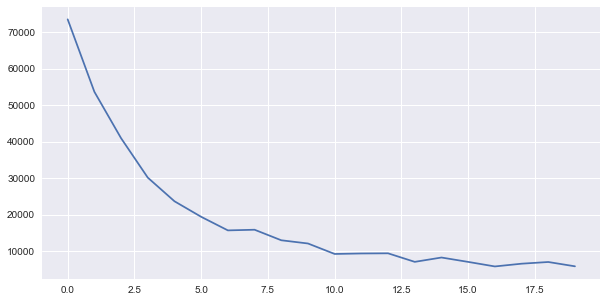

In [7]:
plt.figure(figsize=(10,5))
plt.plot(loss_by_run)
plt.show()

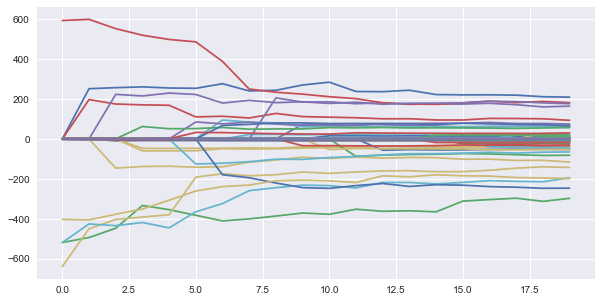

In [8]:
plt.figure(figsize=(10,5))
plt.plot(parameter_by_run)
plt.show()

In [9]:
X = train[features].values
y = train[target].values
X_test = test[features].values
# y_test = test[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

#get model parameters of last run by interation
kml.model.get_param_by_iter()
kml.model.get_loss_by_iter()

print('performance by run')
for i in range(parameter_by_run.shape[0]):
    w=parameter_by_run[i].copy()
    autoencoder_SSE_train = autoencoder_function(X,X,w,shapes+[link])
    autoencoder_SSE_test = autoencoder_function(X_test,X_test,w,shapes+[link])
    print('iteration',i,'train rsquared',1-autoencoder_SSE_train/autoencoder_SST_train,'test rsquared',1-autoencoder_SSE_test/autoencoder_SST_test)

performance by run
iteration 0 train rsquared 0.108687366848 test rsquared 0.112862566588
iteration 1 train rsquared 0.390203777675 test rsquared 0.392402985564
iteration 2 train rsquared 0.545538424563 test rsquared 0.54726032537
iteration 3 train rsquared 0.639775182222 test rsquared 0.641495647564
iteration 4 train rsquared 0.727419653883 test rsquared 0.728298863884
iteration 5 train rsquared 0.780467119874 test rsquared 0.781082890355
iteration 6 train rsquared 0.81018371578 test rsquared 0.810648486157
iteration 7 train rsquared 0.836916636745 test rsquared 0.837258983844
iteration 8 train rsquared 0.864682562001 test rsquared 0.86488174118
iteration 9 train rsquared 0.880393724187 test rsquared 0.880472601922
iteration 10 train rsquared 0.888191446084 test rsquared 0.888237048103
iteration 11 train rsquared 0.897923174608 test rsquared 0.897919967908
iteration 12 train rsquared 0.903481177799 test rsquared 0.903460312612
iteration 13 train rsquared 0.907459986663 test rsquared 0

In [10]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

def get_latent_encoding(X,w_tensor,link):
    w_tensor,extra_w = reshape_vector(w_tensor)
    b1,a1,b2,a2 = extra_w[:4]
    pred = X.dot(w_tensor[0])
    if link == 'linear':
        pred = a1*(pred+b1)
    elif link == 'field_eq':
        pred = -0.5*a1*pred + b1*pred
    elif link == 'log':
        pred = a1*np.log(np.abs(pred)+b1)
    elif link == 'inverse':
        pred = a1/(pred+b1)

    return pred

def reshape_vector(w):
    reshape_w = []
    indx = 0
    for shape,num in zip(shapes[0],shapes[1]):
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape,int(num/shape))
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:]
    print('b1,a1,b2,a2',extra_w)
    return reshape_w,extra_w


#just for fun, we are going to use the latent variables in a predictive model
num_encodings = 5
encoding_dim = 10
X_prime = np.zeros((X.shape[0],num_encodings*encoding_dim))
X_test_prime = np.zeros((X_test.shape[0],num_encodings*encoding_dim))

#lets sample the last three iterations every 2 step (to avoid similarities)
start = 0
for i in np.arange(10,20,2):
    w=parameter_by_run[i].copy()
    X_prime[:,start:start+encoding_dim] = get_latent_encoding(X,w,link)
    X_test_prime[:,start:start+encoding_dim] = get_latent_encoding(X_test,w,link)
    start = start+encoding_dim

b1,a1,b2,a2 [ 77.32310363   0.39562873  24.43818555   0.20731673]
b1,a1,b2,a2 [ 77.32310363   0.39562873  24.43818555   0.20731673]
b1,a1,b2,a2 [ 77.62167563   0.36651636  29.7055958    0.21930156]
b1,a1,b2,a2 [ 77.62167563   0.36651636  29.7055958    0.21930156]
b1,a1,b2,a2 [ 72.41090819   0.34655527  28.71597212   0.22606439]
b1,a1,b2,a2 [ 72.41090819   0.34655527  28.71597212   0.22606439]
b1,a1,b2,a2 [ 75.35029765   0.36152731  28.09549698   0.21874325]
b1,a1,b2,a2 [ 75.35029765   0.36152731  28.09549698   0.21874325]
b1,a1,b2,a2 [ 71.19353932   0.34629325  27.67973919   0.22742662]
b1,a1,b2,a2 [ 71.19353932   0.34629325  27.67973919   0.22742662]


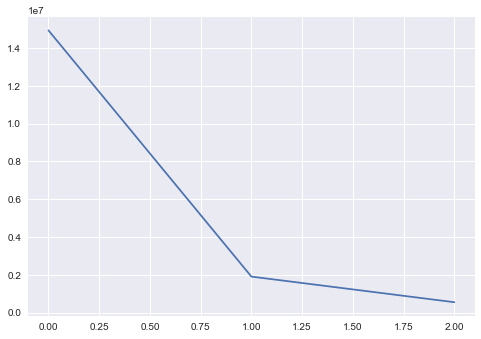

In [23]:
#lets combine the latent variables with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_prime)
    
plt.plot(pca.explained_variance_)
plt.show()

X_prime = pca.transform(X_prime)
X_test_prime = pca.transform(X_test_prime)

In [24]:
latent_corr = {j:[] for j in range(X_prime.shape[1])}
for i in range(X.shape[1]):
    for j in range(X_prime.shape[1]):
        corr = np.corrcoef(X[:,i],X_prime[:,j])[0][1]
        if np.abs(corr)>=0.7:
            print(i,j,'corr',corr)
            latent_corr[j].append(i)

0 2 corr -0.911229980559
4 0 corr 0.979003902781
5 0 corr 0.941507764352
6 0 corr 0.978849519469
9 0 corr 0.753412980763
12 0 corr 0.97897051382
22 0 corr 0.930472324403
23 1 corr 0.714439241622
24 1 corr 0.736040414924
25 1 corr 0.736027875038
26 0 corr 0.980392718018
27 0 corr 0.978961085689
28 0 corr 0.97895899576
29 0 corr 0.794728987378


In [25]:
col_names = np.array(features)

column DER_deltaeta_jet_jet component 0


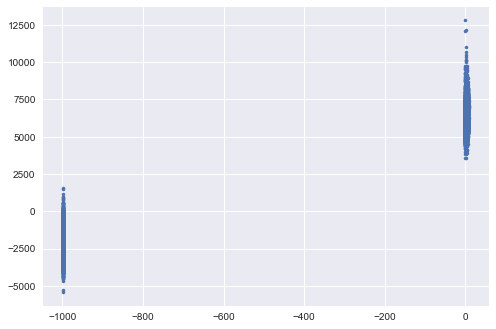

column DER_mass_jet_jet component 0


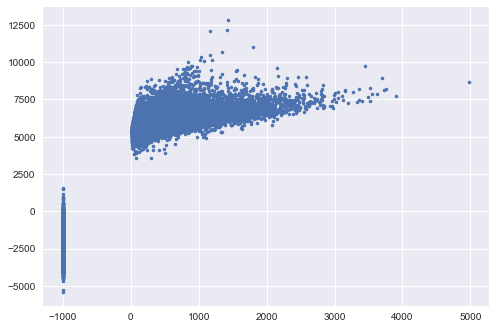

column DER_prodeta_jet_jet component 0


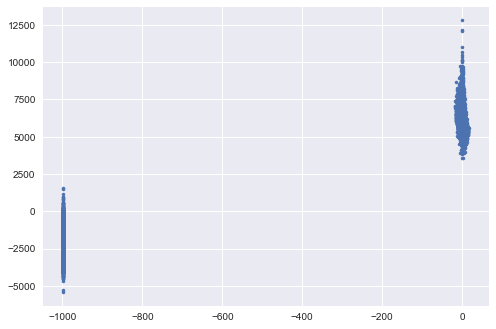

column DER_sum_pt component 0


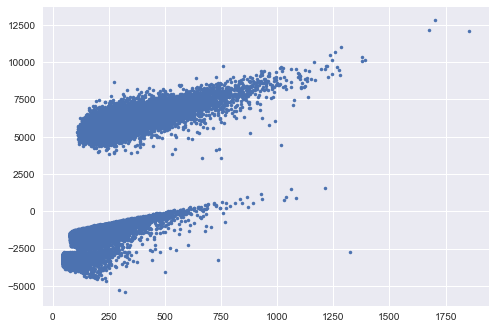

column DER_lep_eta_centrality component 0


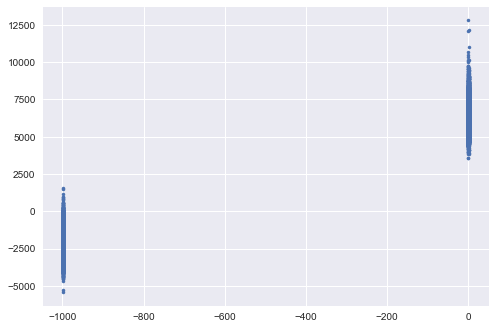

column PRI_jet_num component 0


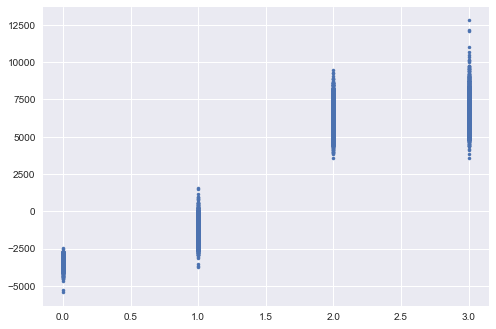

column PRI_jet_subleading_pt component 0


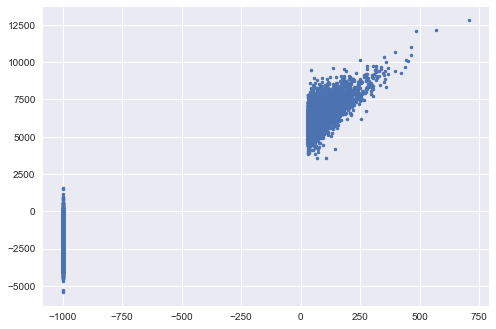

column PRI_jet_subleading_eta component 0


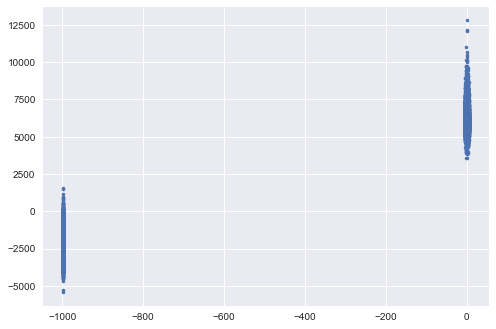

column PRI_jet_subleading_phi component 0


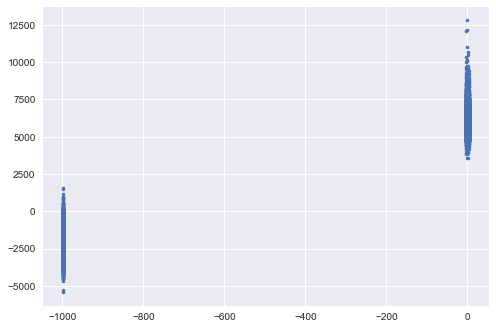

column PRI_jet_all_pt component 0


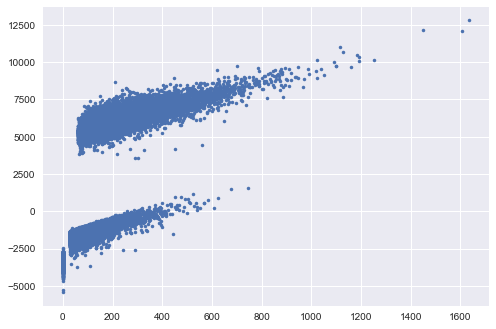

In [26]:
component = 0
indx = latent_corr[component]
for i in indx:
    print('column',col_names[i],'component',component)
    plt.plot(X[:,i],X_prime[:,component],'.')
    plt.show()

column PRI_jet_leading_pt component 1


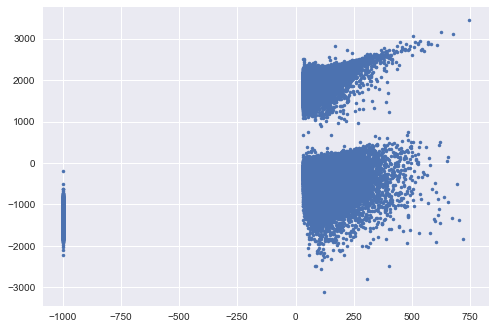

column PRI_jet_leading_eta component 1


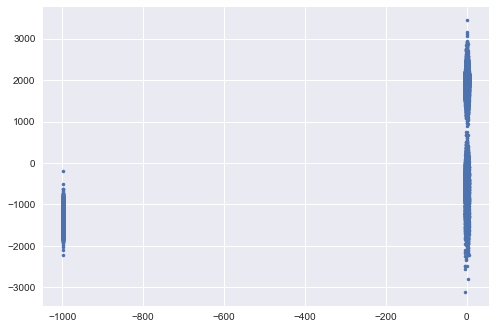

column PRI_jet_leading_phi component 1


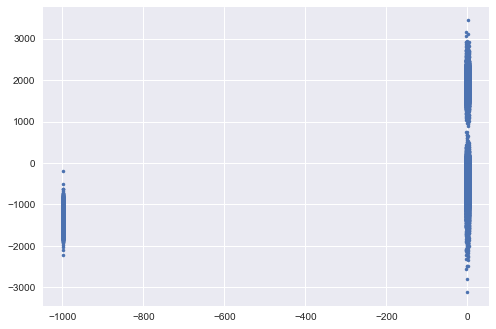

In [27]:
component = 1
indx = latent_corr[component]
for i in indx:
    print('column',col_names[i],'component',component)
    plt.plot(X[:,i],X_prime[:,component],'.')
    plt.show()

column DER_mass_MMC component 2


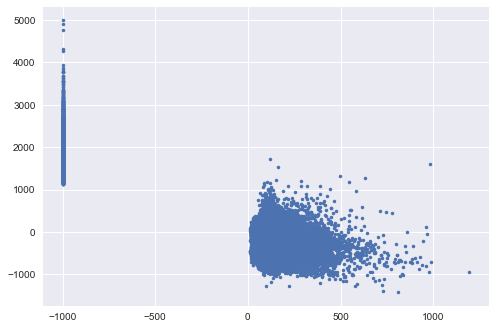

In [28]:
component = 2
indx = latent_corr[component]
for i in indx:
    print('column',col_names[i],'component',component)
    plt.plot(X[:,i],X_prime[:,component],'.')
    plt.show()

In [29]:
#add the original variables to the features set
X_prime = np.column_stack((X,X_prime))
X_test_prime = np.column_stack((X_test,X_test_prime))

In [18]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

def get_acc(predict,y):
    return np.sum((predict>0.5).astype(np.int)==y)/len(y)

Using TensorFlow backend.


In [19]:
#model with latent variable PCA components
input_data = Input(shape=(X_prime.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')

model.fit(X_prime, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test_prime, y_test))


Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.6097 - val_loss: 0.5661
Epoch 2/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5587 - val_loss: 0.5504
Epoch 3/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5450 - val_loss: 0.5412
Epoch 4/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5380 - val_loss: 0.5376
Epoch 5/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5325 - val_loss: 0.5302
Epoch 6/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5290 - val_loss: 0.5285
Epoch 7/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5256 - val_loss: 0.5253
Epoch 8/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5226 - val_loss: 0.5215
Epoch 9/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5197 - va

In [20]:
p_test = model.predict(X_test_prime)
p_train = model.predict(X_prime)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.81325749394004843, 0.81460651685213481)

In [21]:
#model without latent variable PCA components
input_data = Input(shape=(X.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test, y_test))

Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5890 - val_loss: 0.5624
Epoch 2/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5596 - val_loss: 0.5627
Epoch 3/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5525 - val_loss: 0.5538
Epoch 4/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5456 - val_loss: 0.5503
Epoch 5/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5399 - val_loss: 0.5376
Epoch 6/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5375 - val_loss: 0.5342
Epoch 7/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5341 - val_loss: 0.5346
Epoch 8/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5312 - val_loss: 0.5304
Epoch 9/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5276 - va

In [22]:
p_test = model.predict(X_test)
p_train = model.predict(X)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.80023359813121497, 0.80318242545940366)